<a href="https://colab.research.google.com/github/yunlai-wustl/Natural_Image_Recon_from_fMRI_data/blob/main/FMRI_reconstruction_using_BigBiGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

## Setup

In [ ]:
import io
import IPython.display
import PIL.Image
from pprint import pformat
import pandas as pd
import numpy as np
import cv2 
import scipy.io

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from google.colab import drive
drive.mount('/content/drive')
import tensorflow_hub as hub

Instructions for updating:
non-resource variables are not supported in the long term
Mounted at /content/drive


# Generating Images with BigBiGAN


# load imageNet data

In [ ]:
df_training_Img_ID=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Stimulus_Images/image_training_id.csv',header=None,names=['url','ID'])
image_train=np.zeros([1200,256,256,3])
for i,id in enumerate(df_training_Img_ID['ID']):
  img_path='/content/drive/MyDrive/Colab Notebooks/Stimulus_Images/training/'+id
  image = PIL.Image.open(img_path)
  image=np.asarray(image.resize((256,256))) # resize image to 256,256 and convert it to [-1,1], which is required by the encoder
  if(len(image.shape)==2): #grayscale image, convert it to RGB
      image=cv2.cvtColor(np.float32(image), cv2.COLOR_GRAY2BGR)
  image_train[i,:,:,:]=image
  if (i+1) % 100 == 0:
        print(i+1)

100
200
300
400
500
600
700
800
900
1000
1100
1200


In [ ]:
image_train=np.load('/content/drive/MyDrive/Colab Notebooks/img_train.npy')

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/bigbigan_with_tf_hub"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/bigbigan_with_tf_hub.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/bigbigan_with_tf_hub.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/bigbigan_with_tf_hub.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/s?q=experts%2Fbert"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

This notebook is a demo for the *BigBiGAN* models available on [TF Hub](https://tfhub.dev/s?publisher=deepmind&q=bigbigan).

BigBiGAN extends standard (Big)GANs by adding an *encoder* module which can be used for unsupervised representation learning. Roughly speaking, the encoder inverts the generator by predicting latents `z` given real data `x`. See the [BigBiGAN paper on arXiv](https://arxiv.org/abs/1907.02544) [1] for more information about these models.

After connecting to a runtime, get started by following these instructions:

1. (Optional) Update the selected **`module_path`** in the first code cell below to load a BigBiGAN generator for a different encoder architecture.
2. Click **Runtime > Run all** to run each cell in order. Afterwards, the outputs, including visualizations of BigBiGAN samples and reconstructions, should automatically appear below.

Note: if you run into any issues, it can help to click **Runtime > Restart and run all...** to restart your runtime and rerun all cells from scratch.

[1] Jeff Donahue and Karen Simonyan. [Large Scale Adversarial Representation Learning](https://arxiv.org/abs/1907.02544). *arxiv:1907.02544*, 2019.

First, set the module path.
By default, we load the BigBiGAN model with the smaller ResNet-50-based encoder from  **`https://tfhub.dev/deepmind/bigbigan-resnet50/1`**.
To load the larger RevNet-50-x4 based model used to achieve the best representation learning results, comment out the active **`module_path`** setting and uncomment the other.

In [ ]:
# module_path = 'https://tfhub.dev/deepmind/bigbigan-resnet50/1'  # ResNet-50
module_path = 'https://tfhub.dev/deepmind/bigbigan-revnet50x4/1'  # RevNet-50 x4

## Define some functions to display images

In [ ]:
def imgrid(imarray, cols=4, pad=1, padval=255, row_major=True):
  """Lays out a [N, H, W, C] image array as a single image grid."""
  pad = int(pad)
  if pad < 0:
    raise ValueError('pad must be non-negative')
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = N // cols + int(N % cols != 0)
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=padval)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*W, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

def interleave(*args):
  """Interleaves input arrays of the same shape along the batch axis."""
  if not args:
    raise ValueError('At least one argument is required.')
  a0 = args[0]
  if any(a.shape != a0.shape for a in args):
    raise ValueError('All inputs must have the same shape.')
  if not a0.shape:
    raise ValueError('Inputs must have at least one axis.')
  out = np.transpose(args, [1, 0] + list(range(2, len(a0.shape) + 1)))
  out = out.reshape(-1, *a0.shape[1:])
  return out

def imshow(a, format='png', jpeg_fallback=True):
  """Displays an image in the given format."""
  a = a.astype(np.uint8)
  data = io.BytesIO()
  PIL.Image.fromarray(a).save(data, format)
  im_data = data.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

def image_to_uint8(x):
  """Converts [-1, 1] float array to [0, 255] uint8."""
  x = np.asarray(x)
  x = (256. / 2.) * (x + 1.)
  x = np.clip(x, 0, 255)
  x = x.astype(np.uint8)
  return x

def uint8_to_image(x):
  """Converts [0, 255] uint8 to [-1, 1] float array."""
  x = np.asarray(x)
  x = (x / 128)-1
  x = np.clip(x, -1, 1)
  x = x.astype(float)
  return x

## Load a BigBiGAN TF Hub module and display its available functionality

In [ ]:
# module = hub.Module(module_path, trainable=True, tags={'train'})  # training
module = hub.Module(module_path)  # inference

for signature in module.get_signature_names():
  print('Signature:', signature)
  print('Inputs:', pformat(module.get_input_info_dict(signature)))
  print('Outputs:', pformat(module.get_output_info_dict(signature)))
  print()

Signature: default
Inputs: {'x': <hub.ParsedTensorInfo shape=(?, 256, 256, 3) dtype=float32 is_sparse=False>}
Outputs: {'default': <hub.ParsedTensorInfo shape=(?, 120) dtype=float32 is_sparse=False>}

Signature: discriminate
Inputs: {'x': <hub.ParsedTensorInfo shape=(?, 128, 128, 3) dtype=float32 is_sparse=False>,
 'z': <hub.ParsedTensorInfo shape=(?, 120) dtype=float32 is_sparse=False>}
Outputs: {'score_x': <hub.ParsedTensorInfo shape=(?,) dtype=float32 is_sparse=False>,
 'score_xz': <hub.ParsedTensorInfo shape=(?,) dtype=float32 is_sparse=False>,
 'score_z': <hub.ParsedTensorInfo shape=(?,) dtype=float32 is_sparse=False>}

Signature: generate
Inputs: {'z': <hub.ParsedTensorInfo shape=(?, 120) dtype=float32 is_sparse=False>}
Outputs: {'default': <hub.ParsedTensorInfo shape=(?, 128, 128, 3) dtype=float32 is_sparse=False>,
 'upsampled': <hub.ParsedTensorInfo shape=(?, 256, 256, 3) dtype=float32 is_sparse=False>}

Signature: encode
Inputs: {'x': <hub.ParsedTensorInfo shape=(?, 256, 256, 

## Define a wrapper class for convenient access to various functions

In [ ]:
class BigBiGAN(object):

  def __init__(self, module):
    """Initialize a BigBiGAN from the given TF Hub module."""
    self._module = module

  def generate(self, z, upsample=False):
    """Run a batch of latents z through the generator to generate images.

    Args:
      z: A batch of 120D Gaussian latents, shape [N, 120].

    Returns: a batch of generated RGB images, shape [N, 128, 128, 3], range
      [-1, 1].
    """
    outputs = self._module(z, signature='generate', as_dict=True)
    return outputs['upsampled' if upsample else 'default']

  def make_generator_ph(self):
    """Creates a tf.placeholder with the dtype & shape of generator inputs."""
    info = self._module.get_input_info_dict('generate')['z']
    return tf.placeholder(dtype=info.dtype, shape=info.get_shape())

  def gen_pairs_for_disc(self, z):
    """Compute generator input pairs (G(z), z) for discriminator, given z.

    Args:
      z: A batch of latents (120D standard Gaussians), shape [N, 120].

    Returns: a tuple (G(z), z) of discriminator inputs.
    """
    # Downsample 256x256 image x for 128x128 discriminator input.
    x = self.generate(z)
    return x, z

  def encode(self, x, return_all_features=False):
    """Run a batch of images x through the encoder.

    Args:
      x: A batch of data (256x256 RGB images), shape [N, 256, 256, 3], range
        [-1, 1].
      return_all_features: If True, return all features computed by the encoder.
        Otherwise (default) just return a sample z_hat.

    Returns: the sample z_hat of shape [N, 120] (or a dict of all features if
      return_all_features).
    """
    outputs = self._module(x, signature='encode', as_dict=True)
    return outputs if return_all_features else outputs['z_sample']

  def make_encoder_ph(self):
    """Creates a tf.placeholder with the dtype & shape of encoder inputs."""
    info = self._module.get_input_info_dict('encode')['x']
    return tf.placeholder(dtype=info.dtype, shape=info.get_shape())

  def enc_pairs_for_disc(self, x):
    """Compute encoder input pairs (x, E(x)) for discriminator, given x.

    Args:
      x: A batch of data (256x256 RGB images), shape [N, 256, 256, 3], range
        [-1, 1].

    Returns: a tuple (downsample(x), E(x)) of discriminator inputs.
    """
    # Downsample 256x256 image x for 128x128 discriminator input.
    x_down = tf.nn.avg_pool(x, ksize=2, strides=2, padding='SAME')
    z = self.encode(x)
    return x_down, z

  def discriminate(self, x, z):
    """Compute the discriminator scores for pairs of data (x, z).

    (x, z) must be batches with the same leading batch dimension, and joint
      scores are computed on corresponding pairs x[i] and z[i].

    Args:
      x: A batch of data (128x128 RGB images), shape [N, 128, 128, 3], range
        [-1, 1].
      z: A batch of latents (120D standard Gaussians), shape [N, 120].

    Returns:
      A dict of scores:
        score_xz: the joint scores for the (x, z) pairs.
        score_x: the unary scores for x only.
        score_z: the unary scores for z only.
    """
    inputs = dict(x=x, z=z)
    return self._module(inputs, signature='discriminate', as_dict=True)

  def reconstruct_x(self, x, use_sample=True, upsample=False):
    """Compute BigBiGAN reconstructions of images x via G(E(x)).

    Args:
      x: A batch of data (256x256 RGB images), shape [N, 256, 256, 3], range
        [-1, 1].
      use_sample: takes a sample z_hat ~ E(x). Otherwise, deterministically
        use the mean. (Though a sample z_hat may be far from the mean z,
        typically the resulting recons G(z_hat) and G(z) are very
        similar.
      upsample: if set, upsample the reconstruction to the input resolution
        (256x256). Otherwise return the raw lower resolution generator output
        (128x128).

    Returns: a batch of recons G(E(x)), shape [N, 256, 256, 3] if
      `upsample`, otherwise [N, 128, 128, 3].
    """
    if use_sample:
      z = self.encode(x)
    else:
      z = self.encode(x, return_all_features=True)['z_mean']
    recons = self.generate(z, upsample=upsample)
    return recons

  def losses(self, x, z):
    """Compute per-module BigBiGAN losses given data & latent sample batches.

    Args:
      x: A batch of data (256x256 RGB images), shape [N, 256, 256, 3], range
        [-1, 1].
      z: A batch of latents (120D standard Gaussians), shape [M, 120].

    For the original BigBiGAN losses, pass batches of size N=M=2048, with z's
    sampled from a 120D standard Gaussian (e.g., np.random.randn(2048, 120)),
    and x's sampled from the ImageNet (ILSVRC2012) training set with the
    "ResNet-style" preprocessing from:

        https://github.com/tensorflow/tpu/blob/master/models/official/resnet/resnet_preprocessing.py

    Returns:
      A dict of per-module losses:
        disc: loss for the discriminator.
        enc: loss for the encoder.
        gen: loss for the generator.
    """
    # Compute discriminator scores on (x, E(x)) pairs.
    # Downsample 256x256 image x for 128x128 discriminator input.
    scores_enc_x_dict = self.discriminate(*self.enc_pairs_for_disc(x))
    scores_enc_x = tf.concat([scores_enc_x_dict['score_xz'],
                              scores_enc_x_dict['score_x'],
                              scores_enc_x_dict['score_z']], axis=0)

    # Compute discriminator scores on (G(z), z) pairs.
    scores_gen_z_dict = self.discriminate(*self.gen_pairs_for_disc(z))
    scores_gen_z = tf.concat([scores_gen_z_dict['score_xz'],
                              scores_gen_z_dict['score_x'],
                              scores_gen_z_dict['score_z']], axis=0)

    disc_loss_enc_x = tf.reduce_mean(tf.nn.relu(1. - scores_enc_x))
    disc_loss_gen_z = tf.reduce_mean(tf.nn.relu(1. + scores_gen_z))
    disc_loss = disc_loss_enc_x + disc_loss_gen_z

    enc_loss = tf.reduce_mean(scores_enc_x)
    gen_loss = tf.reduce_mean(-scores_gen_z)

    return dict(disc=disc_loss, enc=enc_loss, gen=gen_loss)

## Create tensors to be used later for computing samples, reconstructions, discriminator scores, and losses

In [ ]:
bigbigan = BigBiGAN(module)

# Make input placeholders for x (`enc_ph`) and z (`gen_ph`).
enc_ph = bigbigan.make_encoder_ph()
gen_ph = bigbigan.make_generator_ph()

# Compute samples G(z) from encoder input z (`gen_ph`).
gen_samples = bigbigan.generate(gen_ph)

# Compute reconstructions G(E(x)) of encoder input x (`enc_ph`).
recon_x = bigbigan.reconstruct_x(enc_ph, upsample=True)

# Compute encoder features used for representation learning evaluations given
# encoder input x (`enc_ph`).
enc_features = bigbigan.encode(enc_ph, return_all_features=True)

# Compute discriminator scores for encoder pairs (x, E(x)) given x (`enc_ph`)
# and generator pairs (G(z), z) given z (`gen_ph`).
disc_scores_enc = bigbigan.discriminate(*bigbigan.enc_pairs_for_disc(enc_ph))
disc_scores_gen = bigbigan.discriminate(*bigbigan.gen_pairs_for_disc(gen_ph))

# Compute losses.
losses = bigbigan.losses(enc_ph, gen_ph)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


## Create a TensorFlow session and initialize variables

In [ ]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# Generator samples

First, we'll visualize samples from the pretrained BigBiGAN generator by sampling generator inputs `z` from a standard Gaussian (via `np.random.randn`) and displaying the images it produces. So far we're not going beyond the capabilites of a standard GAN -- we're just using the generator (and ignoring the encoder) for now.

samples shape: (32, 128, 128, 3)


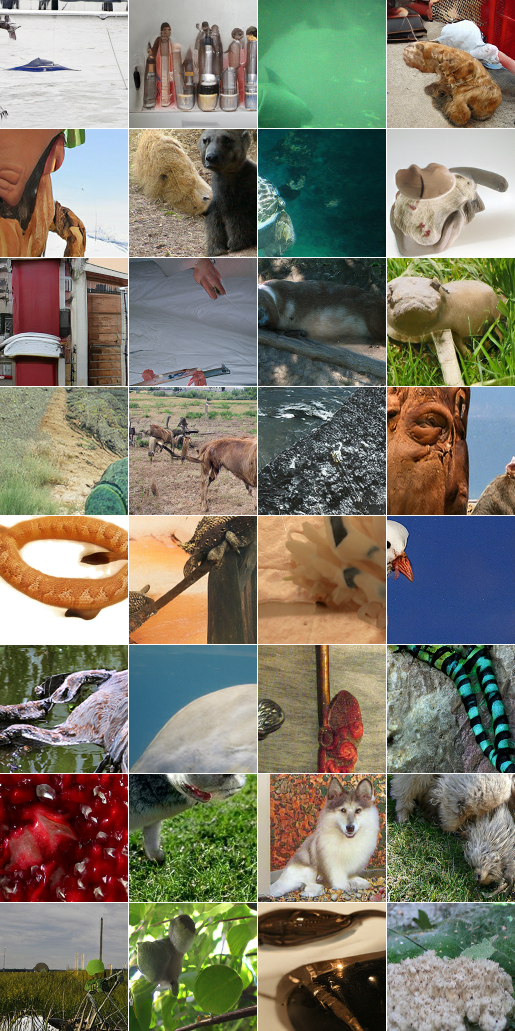

In [ ]:
feed_dict = {gen_ph: np.random.randn(32, 120)}
_out_samples = sess.run(gen_samples, feed_dict=feed_dict)
print('samples shape:', _out_samples.shape)
imshow(imgrid(image_to_uint8(_out_samples), cols=4))

# Reconstruct test images from fMRI data

In [ ]:
from sklearn import preprocessing
mat = scipy.io.loadmat('/content/drive/MyDrive/Colab Notebooks/Stimulus_Images/generated_latent_vector/perceptionTest_Sub3_HaemoShift_0_nback0_latent.mat')
#standard = preprocessing.scale(mat['latent'])


In [ ]:
mat['latent'][mat['latent']>10]=0
mat['latent'][mat['latent']<-10]=0


In [ ]:
import pickle
dbfile = open('/content/predicted_latent_vectors.pickle', 'rb')     
db = pickle.load(dbfile)


In [ ]:
latent=np.array(list(db['sub-03'].values()))

samples shape: (50, 128, 128, 3)


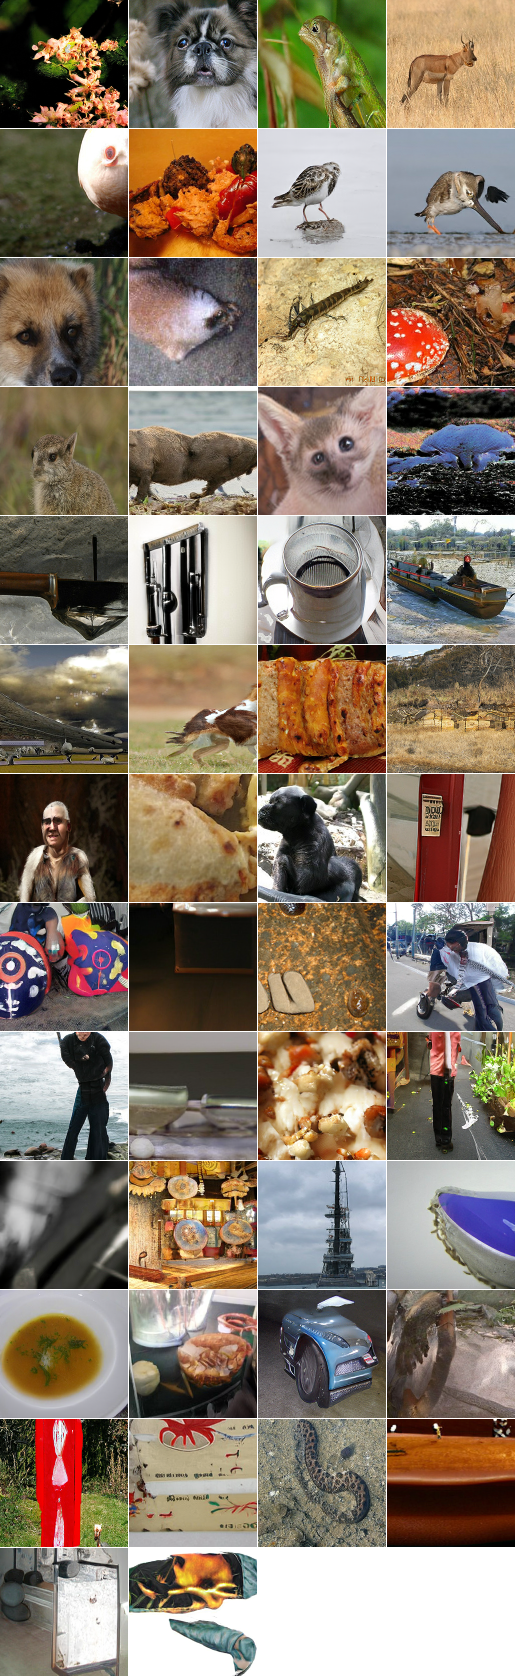

In [ ]:
#mat = scipy.io.loadmat('/content/perceptionTest_Sub1_latent.mat')
#standard = preprocessing.scale(mat['latent'])
#feed_dict = {gen_ph:standard}
#mat['latent'][mat['latent']>3]=0
#mat['latent'][mat['latent']<-3]=0
feed_dict = {gen_ph:latent}

#standard = preprocessing.scale(mat['latent'])
#feed_dict = {gen_ph:standard}
_out_samples = sess.run(gen_samples, feed_dict=feed_dict)
print('samples shape:', _out_samples.shape)
imshow(imgrid(image_to_uint8(_out_samples), cols=4))

samples shape: (50, 128, 128, 3)


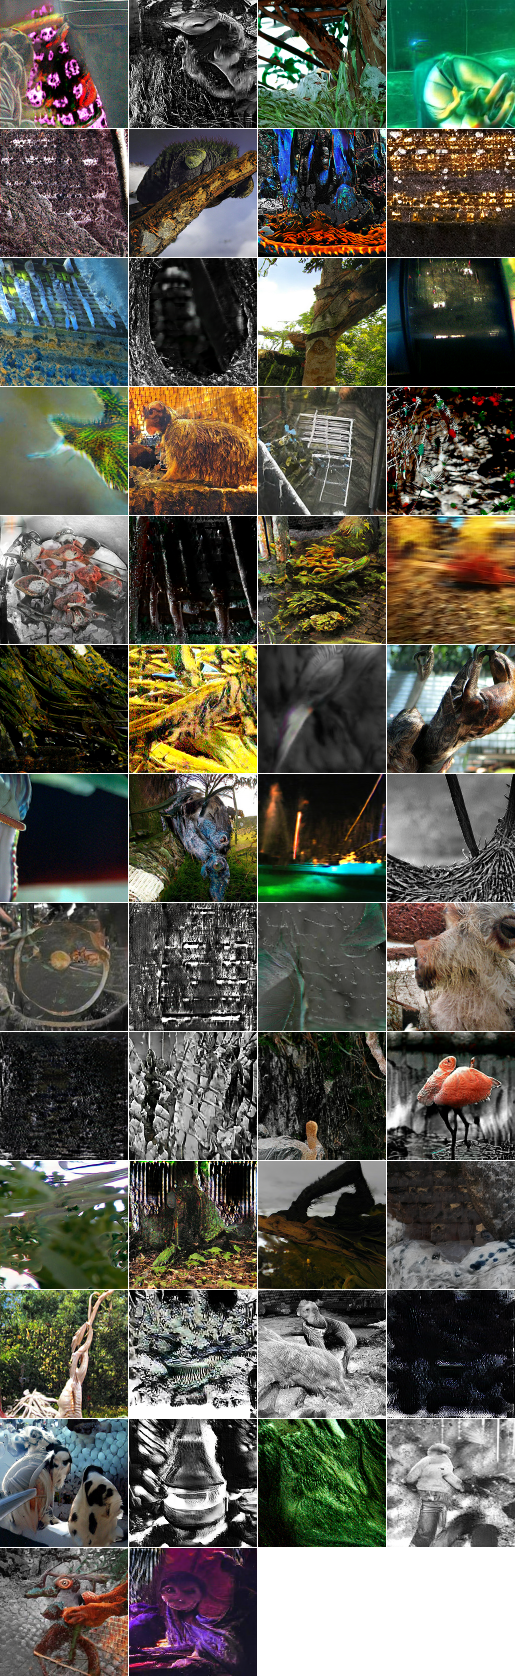

In [ ]:
mat = scipy.io.loadmat('/content/l_test_2.mat')
feed_dict = {gen_ph:mat['l']}
_out_samples = sess.run(gen_samples, feed_dict=feed_dict)
print('samples shape:', _out_samples.shape)
imshow(imgrid(image_to_uint8(_out_samples), cols=4))

samples shape: (50, 128, 128, 3)


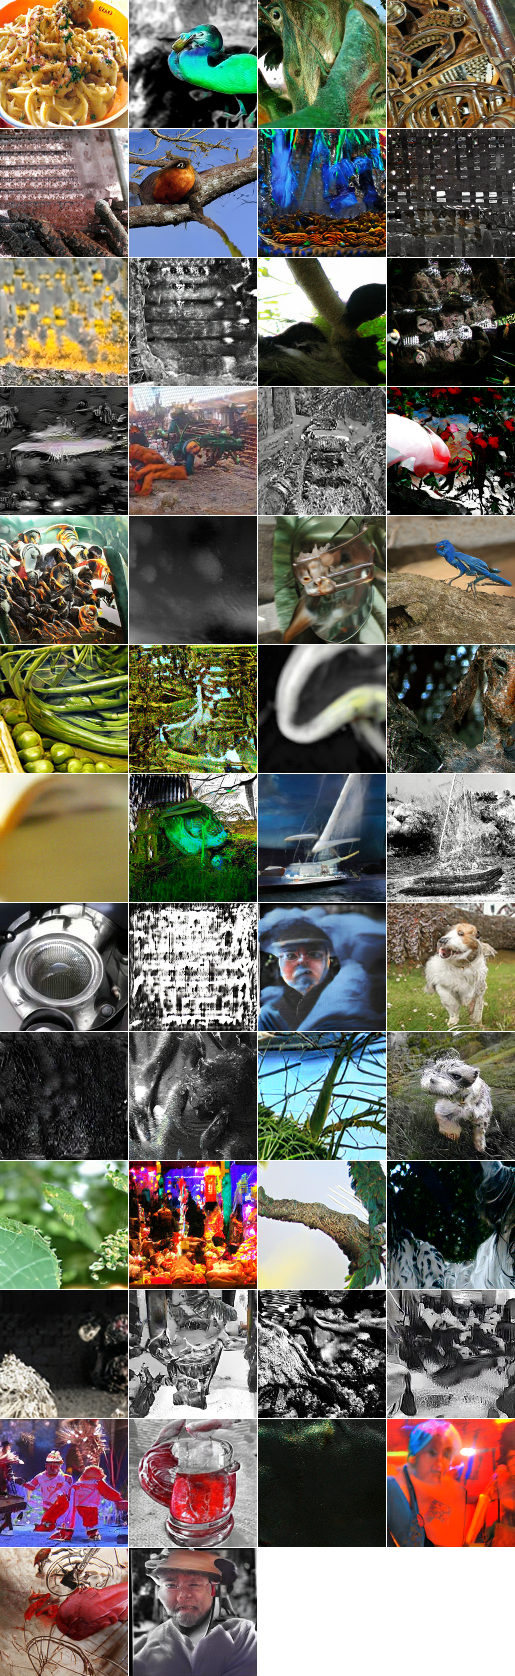

In [ ]:
feed_dict = {gen_ph:mat['l'].T}
_out_samples = sess.run(gen_samples, feed_dict=feed_dict)
print('samples shape:', _out_samples.shape)
imshow(imgrid(image_to_uint8(_out_samples), cols=4))

In [ ]:
df_training_Img_ID=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Stimulus_Images/image_test_id.csv',header=None,names=['url','ID'])
image_test=np.zeros([50,256,256,3])
for i,id in enumerate(df_training_Img_ID['ID']):
  img_path='/content/drive/MyDrive/Colab Notebooks/Stimulus_Images/test/'+id
  image = PIL.Image.open(img_path)
  image=np.asarray(image.resize((256,256))) # resize image to 256,256 and convert it to [-1,1], which is required by the encoder
  if(len(image.shape)==2): #grayscale image, convert it to RGB
      image=cv2.cvtColor(np.float32(image), cv2.COLOR_GRAY2BGR)
  image_test[i,:,:,:]=image


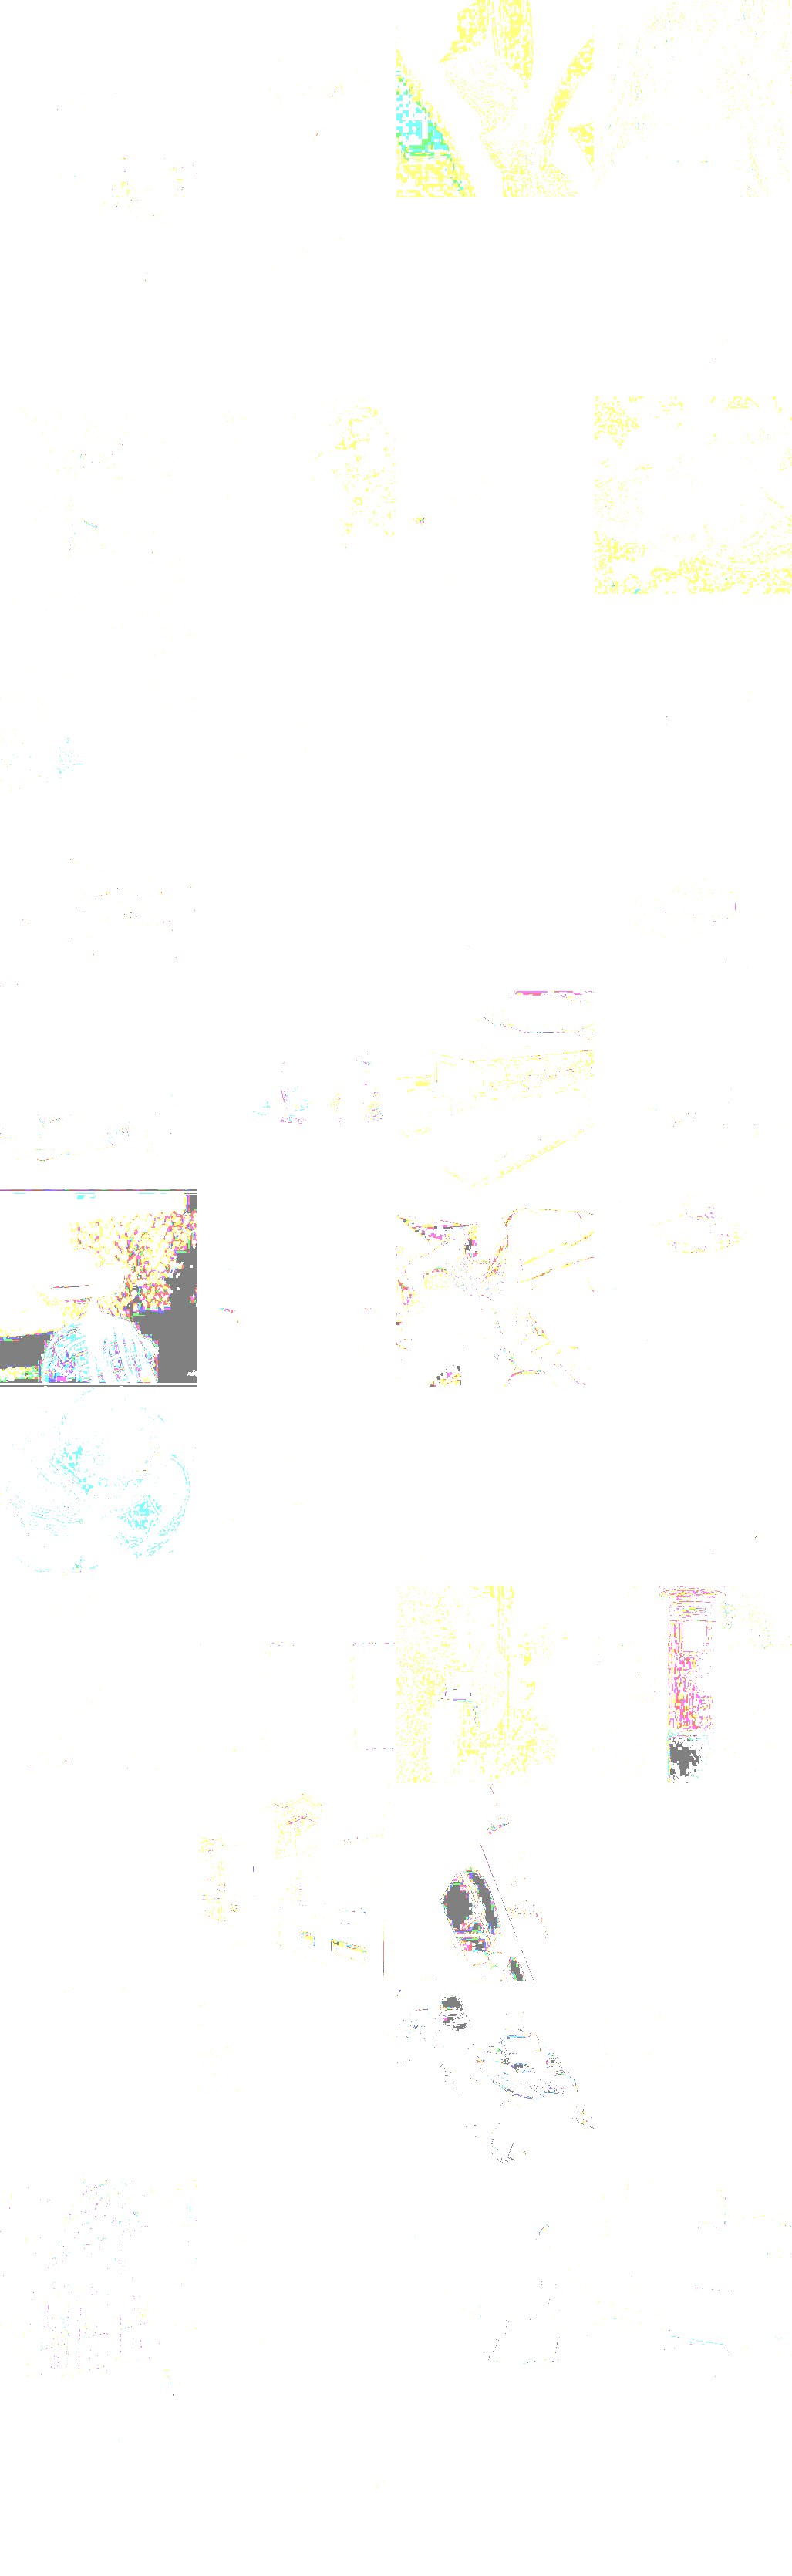

In [ ]:
imshow(imgrid(image_to_uint8(image_test), cols=4))

In [ ]:
inputs_and_recons = interleave(image_test, _out_samples)
print('inputs_and_recons shape:', inputs_and_recons.shape)
imshow(imgrid(image_to_uint8(inputs_and_recons), cols=2))

ValueError: ignored

# Reconstructions

Now we visualize BigBiGAN reconstructions by passing real images through the encoder and back through the generator, computing `G(E(x))` given images `x`.
Below, input images `x` are shown in the left column, and corresponding reconstructions are shown on the right.

Note that reconstructions are not pixel-perfect matches to the input images; rather, they tend to capture the higher level semantic content of the input while "forgetting" most of the low-level detail. This suggests the BigBiGAN encoder may learn to capture the types of high level semantic information about images that we'd like to see in a representation learning approach.

Also note that the raw reconstructions of the 256x256 input images are at the lower resolution produced by our generator -- 128x128. We upsample them for visualization purposes.

In [ ]:

test_images_batch = uint8_to_image(image_test)
_out_recons = sess.run(recon_x, feed_dict={enc_ph: test_images_batch})
print('reconstructions shape:', _out_recons.shape)

inputs_and_recons = interleave(test_images_batch, _out_recons)
print('inputs_and_recons shape:', inputs_and_recons.shape)
imshow(imgrid(image_to_uint8(inputs_and_recons), cols=2))

NameError: ignored

# Encoder features

We now demonstrate how to compute features from the encoder used for standard representation learning evaluations.

These features could be used in a linear or nearest neighbors-based classifier. We include the standard feature taken after the global average pooling (key `avepool_feat`) as well as the larger "BN+CReLU" feature (key `bn_crelu_feat`) used to achieve the best results.

In [ ]:

test_images_batch=uint8_to_image(image_test[0:10])
_out_features = sess.run(enc_features, feed_dict={enc_ph: test_images_batch})


In [ ]:
_out_features['z_mean'].shape

(10, 120)

In [ ]:
arr_all=np.zeros([1200,120])
for i in np.arange(120):
  test_images_batch=uint8_to_image(image_train[i*10:10+i*10])
  _out_features = sess.run(enc_features, feed_dict={enc_ph: test_images_batch})
  arr_all[i*10:10+i*10,:]=_out_features['default']
  print('processing image %d to %d'%(10*i,10+10*i))


processing image 0 to 10
processing image 10 to 20
processing image 20 to 30
processing image 30 to 40
processing image 40 to 50
processing image 50 to 60
processing image 60 to 70
processing image 70 to 80
processing image 80 to 90
processing image 90 to 100
processing image 100 to 110
processing image 110 to 120
processing image 120 to 130
processing image 130 to 140
processing image 140 to 150
processing image 150 to 160
processing image 160 to 170
processing image 170 to 180
processing image 180 to 190
processing image 190 to 200
processing image 200 to 210
processing image 210 to 220
processing image 220 to 230
processing image 230 to 240
processing image 240 to 250
processing image 250 to 260
processing image 260 to 270
processing image 270 to 280
processing image 280 to 290
processing image 290 to 300
processing image 300 to 310
processing image 310 to 320
processing image 320 to 330
processing image 330 to 340
processing image 340 to 350
processing image 350 to 360
processing i

In [ ]:
latent=pd.DataFrame(arr_all)

In [ ]:
latent

0         1         2         3         4         5         6    \
0    -0.167809 -0.107450  0.651773  0.334203 -0.769235  0.465660 -1.887536   
1    -1.756799  1.480898  0.507076 -0.715278 -0.408826 -0.052331 -2.578417   
2     1.243571  2.069099 -0.751498 -0.693078  0.943193 -0.519045 -0.189849   
3    -0.161907 -0.784431 -1.374645 -0.854028 -0.949701  0.407273 -0.818395   
4    -0.245365  1.883097 -1.562195  0.355962  0.048648  0.938006 -1.700778   
...        ...       ...       ...       ...       ...       ...       ...   
1195  0.943436  0.455644  0.368002 -0.567366 -0.071492  1.181522  0.019608   
1196  0.440188 -0.273190 -0.130226 -0.400674  0.393326  0.468130  0.421989   
1197  0.386147 -1.079639  1.681685 -1.531085  0.600485  1.908880 -1.046723   
1198  0.447469  0.495465 -0.026113  0.135810 -0.801937  0.174798 -1.946503   
1199 -1.696156  0.428200 -0.092345  0.043046 -0.462508  0.832144 -0.726692   

           7         8         9    ...       110       111       112  \
0     0.115338  0.835929 -0.416128  ... -0.163786 -0.598966 -0.423568   
1    -0.042468 -0.267359 -0.245402  ...  0.066885  0.010891 -0.191119   
2    -0.373296  0.055577  0.115467  ...  0.089764  0.190650 -0.262349   
3     1.745438  1.896534 -0.865718  ...  0.176279 -0.021682  0.179666   
4     0.921551  0.622073 -0.126572  ... -0.356889 -0.314495 -0.054348   
...        ...       ...       ...  ...       ...       ...       ...   
1195  0.658448  0.635631 -0.498425  ... -0.438896 -0.330595 -0.134799   
1196  1.344181  1.247616 -1.140213  ...  0.209251  0.628790  0.475431   
1197 -2.948745  1.081503 -1.573840  ... -0.046488  0.327317  0.051036   
1198 -2.460067  0.415570 -1.010427  ...  1.055497 -0.439787  0.379352   
1199 -1.993536  0.540293  0.651622  ...  0.906774 -0.068119  0.253831   

           113       114       115       116       117       118       119  
0     0.094966  0.418248 -0.094409  0.007198 -0.209471  0.203790  0.434895  
1     0.216792  0.185509 -0.083866 -0.048571 -0.081946 -0.198615  0.339669  
2    -0.081376  0.372225 -0.186174  0.083335 -0.229881  0.494503  0.227828  
3     0.284877 -0.142695 -0.122749  0.174623 -0.164700  0.235032  0.142204  
4    -0.177161 -0.265169  0.463530 -0.100666  0.012056  0.066692  0.669998  
...        ...       ...       ...       ...       ...       ...       ...  
1195  0.495967  0.097112 -0.110753 -0.263269 -0.077622  1.018977  0.597720  
1196  0.224387  0.239837  0.212337 -0.089642  0.324725  0.204857 -0.456266  
1197  0.001015 -0.130023  0.750358  0.824044 -0.368085 -0.785715  0.293676  
1198 -0.151399  0.519906  0.263762 -0.070197  0.434619  0.288713  0.434562  
1199  0.016030  0.457656  0.379345  0.192954 -0.428402 -0.032524  0.571936  

[1200 rows x 120 columns]

In [ ]:
result = pd.concat([df_training_Img_ID, latent], axis=1)
result.to_csv("image_id_latent.csv")

In [ ]:
from scipy.io import savemat
savemat("/content/drive/MyDrive/Colab Notebooks/Stimulus_Images/latent_vector_new.mat",{'latent_vector':arr_all})

In [ ]:
df_training_Img_ID=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Stimulus_Images/image_training_id.csv',header=None,names=['url','ID'])
df_training_Img_ID['ID']

0        n01518878_5958.JPEG
1        n01518878_7346.JPEG
2        n01518878_7579.JPEG
3        n01518878_8432.JPEG
4       n01518878_10042.JPEG
                ...         
1195     n13111881_9170.JPEG
1196    n13111881_10917.JPEG
1197    n13111881_11914.JPEG
1198    n13111881_15726.JPEG
1199    n13111881_28475.JPEG
Name: ID, Length: 1200, dtype: object

In [ ]:
_out_features['default']

array([[-2.4536574e-01,  1.8830962e+00, -1.5621947e+00, ...,
         1.2056144e-02,  6.6692173e-02,  6.6999805e-01],
       [ 6.4992052e-01, -5.3457004e-01, -3.2738754e-01, ...,
         2.0929600e-01,  3.2534888e-01,  5.0776291e-01],
       [ 5.1620883e-01,  3.3728153e-01,  6.7098773e-01, ...,
        -1.6926882e-01, -2.7203187e-01,  3.1982419e-01],
       ...,
       [-2.2125050e-01,  8.1842285e-01,  1.4522201e+00, ...,
        -1.2339757e-01, -2.8689837e-01,  1.5713219e-01],
       [-1.5071479e+00,  5.9890175e-01, -8.9412391e-01, ...,
         2.2161596e-01, -3.2719517e-01, -2.5308442e-01],
       [ 9.0404946e-01, -6.3536483e-01,  1.9504178e+00, ...,
        -1.5928762e-01, -7.6542143e-04, -2.4450232e-01]], dtype=float32)

In [ ]:
feed_dict = {gen_ph: _out_features['default']}
_out_samples = sess.run(gen_samples, feed_dict=feed_dict)
print('samples shape:', _out_samples.shape)
imshow(imgrid(image_to_uint8(_out_samples), cols=4))

NameError: ignored

# Discriminator scores and losses

Finally, we'll compute the discriminator scores and losses on batches of encoder and generator pairs. These losses could be passed into an optimizer to train BigBiGAN.

We use our batch of images above as the encoder inputs `x`, computing the encoder score as `D(x, E(x))`. For the generator inputs we sample `z` from a 120D standard Gaussian via `np.random.randn`, computing the generator score as `D(G(z), z)`.

The discriminator predicts a joint score `score_xz` for the `(x, z)` pairs as well as unary scores `score_x` and `score_z` for `x` and `z` alone, respectively. It's trained to give high (positive) scores to encoder pairs and low (negative) scores to generator pairs. This mostly holds below, though the unary `score_z` is negative in both cases, indicating that the encoder outputs `E(x)` resemble actual samples from a Gaussian.

In [ ]:
feed_dict = {enc_ph: test_images, gen_ph: np.random.randn(32, 120)}
_out_scores_enc, _out_scores_gen, _out_losses = sess.run(
    [disc_scores_enc, disc_scores_gen, losses], feed_dict=feed_dict)
print('Encoder scores:', {k: v.mean() for k, v in _out_scores_enc.items()})
print('Generator scores:', {k: v.mean() for k, v in _out_scores_gen.items()})
print('Losses:', _out_losses)